# Importing Libraries

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Importing Dataset
from tensorflow.keras.datasets import mnist

# Importing Data Preprocessing Tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Importing Image Preprocessing Tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

# Importing models
from models import ResNet

# Importing Evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Importing Statistical Tools
from scipy.stats import skew

In [17]:
EPOCHS = 50
INIT_LR = 1e-1
BATCH_SIZE = 256

In [18]:
((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()

# Combining test and train data
data = np.vstack([trainData, testData])
labels = np.hstack([trainLabels, testLabels])

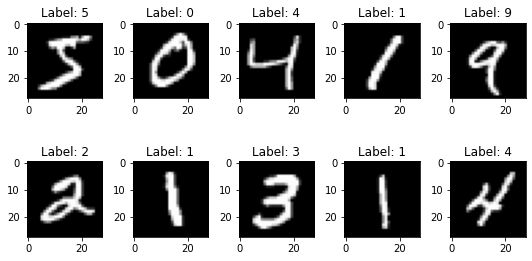

In [19]:
# Visualizing MNIST Dataset
row = 2
col = 5
fig, axes = plt.subplots(row, col, figsize=(1.5*col,2*row))
for i in range(10):
    ax = axes[i//col, i%col]
    ax.imshow(data[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [20]:
# Resizing images to 32x32
data = [cv2.resize(image, (32,32)) for image in data]

# Converting to float
data = np.array(data, dtype="float32")

# Reduce array to single column
data = np.expand_dims(data, axis=-1)

# Normalize Images
data = data/255.0

In [21]:
# Binarize the Labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Checking skewness in dataset
classTotals = labels.sum(axis=0)
print("skewness:", skew(classTotals))

# Accounting Skewness by calculating weights
classWeight = {}
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]
print("skewness after accounting:", skew(list(classWeight)))

skewness: 0.6705417444349553
skewness after accounting: 0.0


In [22]:
# Splitting data into training (80%) and testing (20%)
X, testX, Y, testY = train_test_split(data,
                                      labels,
                                      test_size=0.20,
                                      stratify=labels,
                                      random_state=42)

In [23]:
# Splitting train data into training (80%) and testing (20%)
trainX, valX, trainY, valY = train_test_split(X,
                                              Y,
                                              test_size=0.20,
                                              stratify=Y,
                                              random_state=42)

In [24]:
# Initializing the Image Data Generator
# rotation_range        - value in degrees (0-180)  - A range within which to randomly rotate pictures
# zoom_range                                        - A range for randomly zooming inside pictures
# width_shift_range     - fraction of total width   - A range to randomly translate pictures vertically
# height_shift_range    - fraction of total height  - A range to randomly translate pictures horizontally
# shear_range                                       - A range for randomly applying shearing transformations
# horizontal_flip                                   - A range for randomly flipping half of the images horizontally
# fill_mode                                         - The strategy used for filling in newly created pixels
datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.05,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.15,
                             horizontal_flip=False,
                             fill_mode="nearest")

In [25]:
opt = SGD(learning_rate=INIT_LR, decay= INIT_LR / EPOCHS)

In [26]:
# Resnet.build(width, height, depth, 
#              classes, 
#              stages, 
#              filters,
#              reg=0.0001)

model = ResNet.build(32, 32, 1, 
                     len(lb.classes_), 
                     (3, 3, 3), 
                     (64, 64, 128, 256), 
                     reg=0.0005)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [27]:
# Train the network
#print("[INFO] Training network...")
#history = model.fit(datagen.flow(trainX, trainY, batch_size=BATCH_SIZE),
#                    validation_data=(valX, valY),
#                    steps_per_epoch=len(trainX) // BATCH_SIZE,
#                    epochs=EPOCHS,
#                    class_weight=classWeight,
#                    verbose=1)
# ------------------------------------------------------------------------
# Model saved on 2 Jan, 2022
# ------------------------------------------------------------------------

In [28]:
# Define the list of label names
labelNames = "0123456789"
#labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]
print(labelNames)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [14]:
# Evaluate the network
print("[INFO] Evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1), 
                            target_names=labelNames))

[INFO] Evaluating network...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1381
           1       0.99      0.99      0.99      1575
           2       0.99      0.99      0.99      1398
           3       0.99      0.99      0.99      1428
           4       0.99      0.99      0.99      1365
           5       0.99      0.99      0.99      1263
           6       0.99      0.99      0.99      1375
           7       0.99      0.99      0.99      1458
           8       1.00      0.98      0.99      1365
           9       0.98      0.99      0.99      1392

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



In [15]:
# Save the model to disk
print("[INFO] Serializing network...")
model.save("models/trained_MNIST_model")

[INFO] Serializing network...
INFO:tensorflow:Assets written to: models/trained_MNIST_model\assets


C:\Users\Ahmef\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Ahmef\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


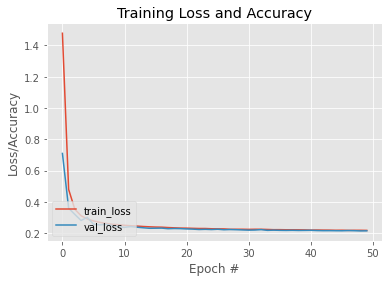

In [16]:
# Construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# Loading and Evaluating the Model

In [29]:
model = load_model("models/trained_MNIST_model")

In [30]:
# Evaluate the network
print("[INFO] Evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1), 
                            target_names=labelNames))

[INFO] Evaluating network...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1381
           1       0.99      0.99      0.99      1575
           2       0.99      0.99      0.99      1398
           3       0.99      0.99      0.99      1428
           4       0.99      0.99      0.99      1365
           5       0.99      0.99      0.99      1263
           6       0.99      0.99      0.99      1375
           7       0.99      0.99      0.99      1459
           8       1.00      0.98      0.99      1365
           9       0.98      0.99      0.99      1391

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



<AxesSubplot:>

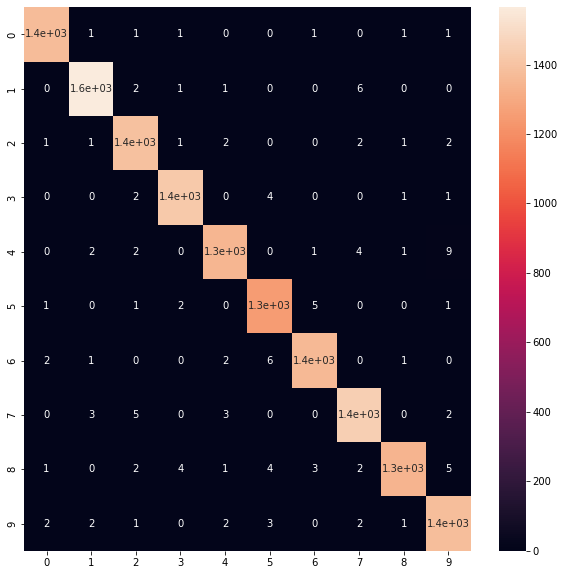

In [46]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1)), annot = True, ax=ax) 